# NICE (MNIST)

Logisic ditribution prior used
$$
p_Z(z)=\frac{1}{(1+e^{-z})(1+e^{z})}=\frac{e^z}{(1+e^z)^2}=\frac{e^{-z}}{(1+e^{-
z})^2}\\
\log(p_Z(z))=-\log(1+e^z)-\log(1+e^{-z})\\
F_Z(t)=\int^t_{-\infty}p_Z(z)\;dz=\frac{1}{1+e^{-t}}
$$


![logistic_distribution-2.png](attachment:logistic_distribution-2.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

batch_size = 128
(full_dim, mid_dim, hidden) = (1 * 28 * 28, 1000, 5)
lr = 1e-3
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


############################################
# STEP 1: Define dataset and preprocessing #
############################################

trainset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:

#####################################
# STEP 2: Define prior distribution #
#####################################

class Logistic(torch.distributions.Distribution):
    def __init__(self):
        super(Logistic, self).__init__()

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
        return torch.log(z) - torch.log(1. - z)
    

In [3]:

####################################
# STEP 3: Implement Coupling Layer #
####################################

class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
        super(Coupling, self).__init__()
        self.mask_config = mask_config
        
        self.in_block = nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
        self.mid_block = nn.ModuleList([nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU())
                                                                 for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        if self.mask_config:
            on, off = x[:, :, 0], x[:, :, 1]
        else:
            off, on = x[:, :, 0], x[:, :, 1]

        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        
        if reverse:
            on = on - shift
        else:
            on = on + shift

        if self.mask_config:
            x = torch.stack((on, off), dim=2)
        else:
            x = torch.stack((off, on), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J
    

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:46: UserWarning: <class '__main__.Logistic'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


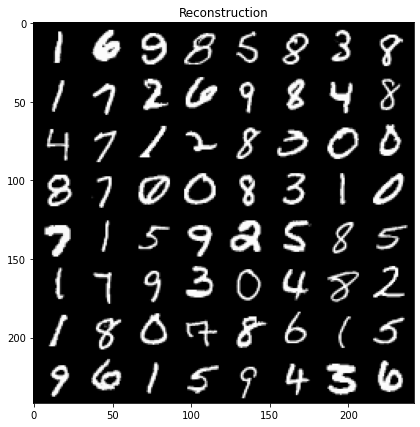

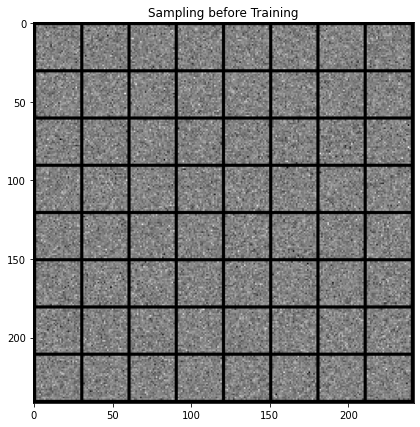

In [4]:

##########################
# STEP 4: Implement NICE #
##########################

class NICE(nn.Module):
    def __init__(self,in_out_dim, mid_dim, hidden, mask_config=1.0, coupling=4):
        super(NICE, self).__init__()
        self.prior = Logistic()
        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden, 
                     mask_config=(mask_config+i)%2) \
            for i in range(coupling)])
        
        self.scaling = Scaling(in_out_dim)

    def g(self, z):
        x, _ = self.scaling(z, reverse=True)
        for i in reversed(range(len(self.coupling))):
            x = self.coupling[i](x, reverse=True)
        return x

    def f(self, x):
        for i in range(len(self.coupling)):
            x = self.coupling[i](x)
        z, log_det_J = self.scaling(x)
        return z, log_det_J

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_ll = torch.sum(self.prior.log_prob(z), dim=1)
        return log_ll + log_det_J

    def sample(self, size):
        z = self.prior.sample((size, self.in_out_dim)).to(device)
        return self.g(z)

    def forward(self, x):
        return self.log_prob(x)

    
'''
Instantiate model & define optimizer
'''

nice = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)

optimizer = torch.optim.Adam(nice.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-4)



'''
Visualize reconstructed image & sampled image BEFORE TRAINING
'''

for i, data in enumerate(train_loader,1):   
    inputs, _ = data
    inputs = inputs.to(device)
#     inputs = dequantize(inputs)
    inputs = inputs.view(-1, 784)
    break
    
with torch.no_grad():
    z, _ = nice.f(inputs)
    reconst = nice.g(z)
    reconst = reconst.view(-1, 1, 28, 28)
    samples = nice.sample(64)
    samples = samples.view(-1, 1, 28, 28)
    save_image(reconst[:64], "before_training_reconstruction.png")
    save_image(samples, "before_training_sample.png")
    
    plt.figure(figsize = (7,7))
    plt.title('Reconstruction')
    plt.imshow(make_grid(reconst[:64].cpu(), normalize=True).permute(1,2,0))

    plt.figure(figsize = (7,7))
    plt.title('Sampling before Training')
    plt.imshow(make_grid(samples.cpu(), normalize=True).permute(1,2,0))
    
    

1th epoch, loss_mean tensor(915.5726, device='cuda:0', grad_fn=<DivBackward0>)


5th epoch, loss_mean tensor(-416.2814, device='cuda:0', grad_fn=<DivBackward0>)


10th epoch, loss_mean tensor(-1387.1365, device='cuda:0', grad_fn=<DivBackward0>)


20th epoch, loss_mean tensor(-2085.4487, device='cuda:0', grad_fn=<DivBackward0>)


50th epoch, loss_mean tensor(-2285.0374, device='cuda:0', grad_fn=<DivBackward0>)


90th epoch, loss_mean tensor(-2348.7297, device='cuda:0', grad_fn=<DivBackward0>)


100th epoch, loss_mean tensor(-2355.9478, device='cuda:0', grad_fn=<DivBackward0>)


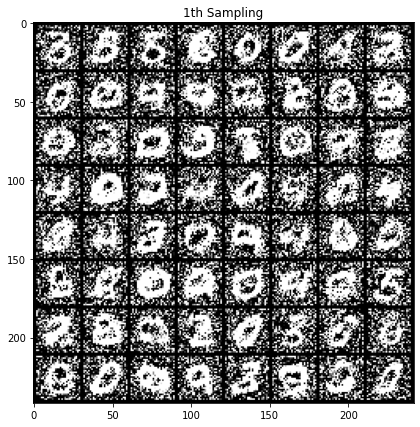

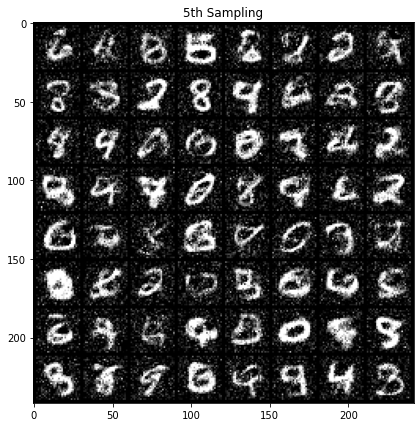

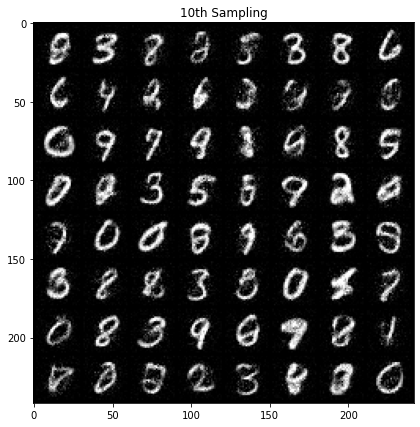

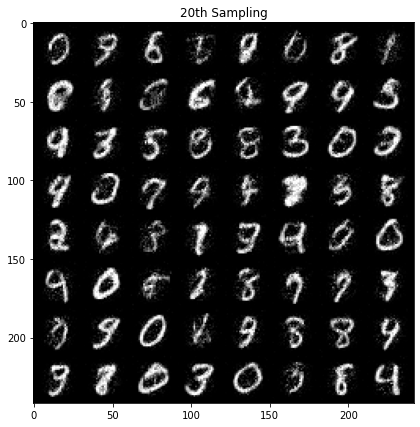

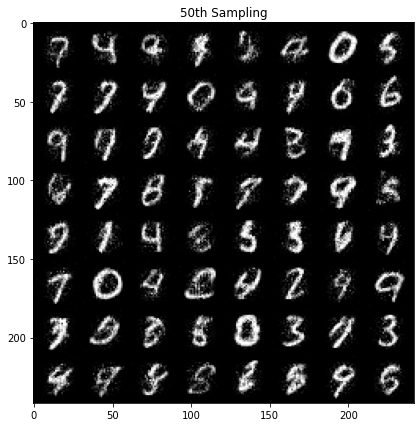

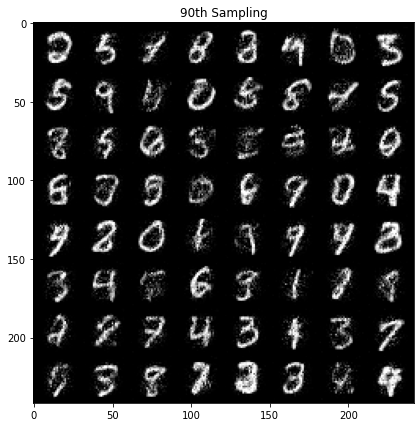

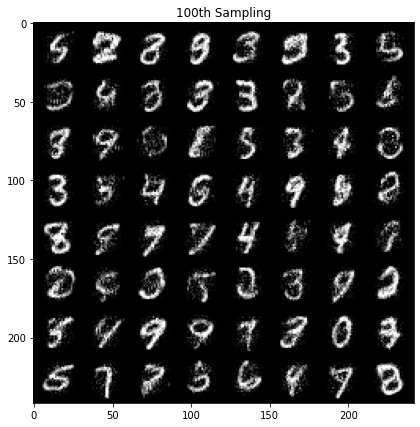

In [5]:

####################
# STEP 4: Training #
####################

for epoch in range(1,epochs+1):
    running_loss = 0
    for i, data in enumerate(train_loader,1):
        optimizer.zero_grad()    
        inputs, _ = data
        inputs = inputs.to(device)
#         inputs = dequantize(inputs)
        inputs = inputs.view(-1, 784)

        loss = -nice(inputs).mean()
        running_loss += loss

        loss.backward()
        optimizer.step()

    loss_mean = running_loss / (len(trainset)//batch_size)
    
    if epoch in [1,5,10,20,50,90,100]:
        print("{}th epoch, loss_mean".format(epoch), loss_mean)
        with torch.no_grad():
            z, _ = nice.f(inputs)
            samples = nice.sample(64)
            samples = samples.view(-1, 1, 28, 28)
            save_image(samples, "{}th_epoch_sample.png".format(epoch))
            samples = samples.view(-1, 1, 28, 28)
            plt.figure(figsize = (7,7))
            plt.title('{}th Sampling'.format(epoch))
            plt.imshow(make_grid(samples.cpu()).permute(1,2,0))